# CS6421 Programming Assignment 2 - Autoencoders

---

This notebook consists of 3 tasks as follows - 
<ol>
  <li> Task 1 - Basic Autoencoder </li>
  <li> Task 2 - Denoising Autoencoder </li>
  <li> Task 3 - Text Reconstruction Application </li>
</ol>

The discussions of each task and their corresponding models are provided in a separate document labelled as <u>CS6421 - Assignment 2 Report.pdf</u>.

The following applies to all the tasks - By submitting this exam, I declare
<ol>
  <li> that all work of it is my own;</li>
  <li> that I did not seek whole or partial solutions for any part of my submission from others; and</li>
  <li> that I did not and will not discuss, exchange, share, or publish complete or partial solutions for this exam or any part of it.</li>
</ol>

# Import Libraries

In [29]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imsave
from keras.preprocessing.image import load_img, array_to_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Input, LeakyReLU, BatchNormalization, Dropout
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from __future__ import absolute_import, division, print_function, unicode_literals

# Task 1 - Basic Autoencoder

## Read Images

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train / 255.

x_train = x_train.astype(np.float32)
x_train = np.reshape(x_train, (x_train.shape[0], 784))
x_test = np.reshape(x_test, (x_test.shape[0], 784))

training_dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(256)

11493376/11490434 [==============================] - 0s 0us/step


## Dense, Multi Layer Model (Given)

### Define Model Architecture

In [38]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim):
        super(Encoder, self).__init__()
        self.hidden_layer = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.relu)
        self.output_layer = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.relu)
    
    def call(self, input_features):
        activation = self.hidden_layer(input_features)
        return self.output_layer(activation)

class Decoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim, original_dim):
        super(Decoder, self).__init__()
        self.hidden_layer = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.relu)
        self.output_layer = tf.keras.layers.Dense(units=original_dim, activation=tf.nn.relu)
  
    def call(self, code):
        activation = self.hidden_layer(code)
        return self.output_layer(activation)

class Autoencoder(tf.keras.Model):
    def __init__(self, intermediate_dim, original_dim):
        super(Autoencoder, self).__init__()
        self.loss = []
        self.encoder = Encoder(intermediate_dim=intermediate_dim)
        self.decoder = Decoder(intermediate_dim=intermediate_dim, original_dim=original_dim)

    def call(self, input_features):
        code = self.encoder(input_features)
        reconstructed = self.decoder(code)
        return reconstructed

### Define Loss, Training and Training Loop Functions 

In [5]:
def loss(preds, real):
  return tf.reduce_mean(tf.square(tf.subtract(preds, real)))

def train(loss, model, opt, original):
  with tf.GradientTape() as tape:
    preds = model(original)
    reconstruction_error = loss(preds, original)
  gradients = tape.gradient(reconstruction_error, model.trainable_variables)
  gradient_variables = zip(gradients, model.trainable_variables)
  opt.apply_gradients(gradient_variables)
  
  return reconstruction_error

def train_loop(model, opt, loss, dataset, epochs):
  for epoch in range(epochs):
    epoch_loss = 0
    for step, batch_features in enumerate(dataset):
      loss_values = train(loss, model, opt, batch_features)
      epoch_loss += loss_values
    model.loss.append(epoch_loss)
    print('Epoch {}/{}. Loss: {}'.format(epoch + 1, epochs, epoch_loss.numpy()))

### Fit Model and Display Reconstructions

In [14]:
model = Autoencoder(intermediate_dim=128, original_dim=784)
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)

train_loop(model, opt, loss, training_dataset, 20)

Epoch 1/20. Loss: 9.339157104492188
Epoch 2/20. Loss: 6.055464267730713
Epoch 3/20. Loss: 5.5558648109436035
Epoch 4/20. Loss: 5.33915901184082
Epoch 5/20. Loss: 5.225047588348389
Epoch 6/20. Loss: 5.118475437164307
Epoch 7/20. Loss: 5.0644097328186035
Epoch 8/20. Loss: 5.000614166259766
Epoch 9/20. Loss: 4.94410514831543
Epoch 10/20. Loss: 4.945681095123291
Epoch 11/20. Loss: 4.912580966949463
Epoch 12/20. Loss: 4.911304950714111
Epoch 13/20. Loss: 4.897470474243164
Epoch 14/20. Loss: 4.890329837799072
Epoch 15/20. Loss: 4.829795837402344
Epoch 16/20. Loss: 4.822689056396484
Epoch 17/20. Loss: 4.8363728523254395
Epoch 18/20. Loss: 4.801143169403076
Epoch 19/20. Loss: 4.790028095245361
Epoch 20/20. Loss: 4.77601957321167


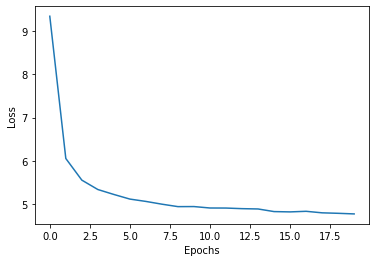

In [15]:
plt.plot(range(20), model.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

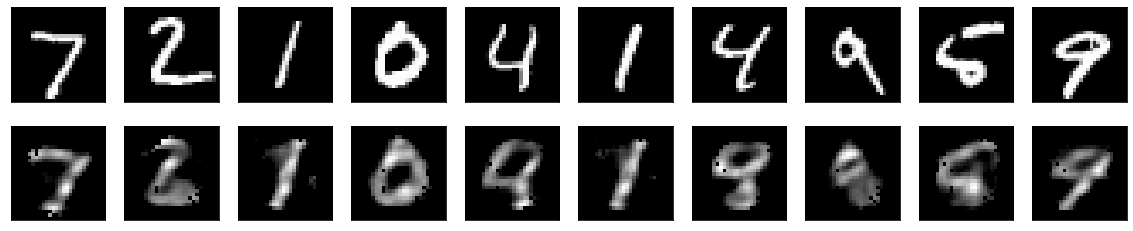

In [16]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(model(x_test)[index].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Dense, Multi Layer Model #1



### Define Model Architecture

In [30]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim_1, intermediate_dim_2):
        super(Encoder, self).__init__()
        self.hidden_layer_1 = Dense(units=intermediate_dim_1, activation="relu")
        self.hidden_layer_2 = Dense(units=intermediate_dim_2, activation="relu")
        self.output_layer = Dense(units=intermediate_dim_2, activation="relu")
    
    def call(self, input_features):
        hid_layer_1 = self.hidden_layer_1(input_features)
        hid_layer_2 = self.hidden_layer_2(hid_layer_1)
        return self.output_layer(hid_layer_2)

class Decoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim_1, original_dim):
        super(Decoder, self).__init__()
        self.hidden_layer_1 = Dense(units=intermediate_dim_1, activation="relu")
        self.output_layer = Dense(units=original_dim, activation="sigmoid")
  
    def call(self, code):
        hid_layer_1 = self.hidden_layer_1(code)
        return self.output_layer(hid_layer_1)

class Autoencoder(tf.keras.Model):
    def __init__(self, intermediate_dim_1, intermediate_dim_2, original_dim):
      super(Autoencoder, self).__init__()
        self.loss = []
        self.encoder = Encoder(intermediate_dim_1=intermediate_dim_1, intermediate_dim_2=intermediate_dim_2)
        self.decoder = Decoder(intermediate_dim_1=intermediate_dim_2, original_dim=original_dim)

    def call(self, input_features):
        code = self.encoder(input_features)
        reconstructed = self.decoder(code)
        return reconstructed

### Fit Model and Display Reconstructions

In [31]:
model_1 = Autoencoder(intermediate_dim_1=128, intermediate_dim_2=64, original_dim=784)
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)

train_loop(model_1, opt, loss, training_dataset, 100)

Epoch 1/100. Loss: 10.888432502746582
Epoch 2/100. Loss: 5.6941046714782715
Epoch 3/100. Loss: 4.50474214553833
Epoch 4/100. Loss: 3.9802873134613037
Epoch 5/100. Loss: 3.6011962890625
Epoch 6/100. Loss: 3.3309450149536133
Epoch 7/100. Loss: 3.158250093460083
Epoch 8/100. Loss: 2.995419979095459
Epoch 9/100. Loss: 2.9146809577941895
Epoch 10/100. Loss: 2.8584423065185547
Epoch 11/100. Loss: 2.7961206436157227
Epoch 12/100. Loss: 2.7470641136169434
Epoch 13/100. Loss: 2.7201006412506104
Epoch 14/100. Loss: 2.6941349506378174
Epoch 15/100. Loss: 2.6322007179260254
Epoch 16/100. Loss: 2.6270480155944824
Epoch 17/100. Loss: 2.6094915866851807
Epoch 18/100. Loss: 2.644700527191162
Epoch 19/100. Loss: 2.5808265209198
Epoch 20/100. Loss: 2.5927047729492188
Epoch 21/100. Loss: 2.5409469604492188
Epoch 22/100. Loss: 2.528923273086548
Epoch 23/100. Loss: 2.578436851501465
Epoch 24/100. Loss: 2.5024333000183105
Epoch 25/100. Loss: 2.5195152759552
Epoch 26/100. Loss: 2.4982335567474365
Epoch 27/10

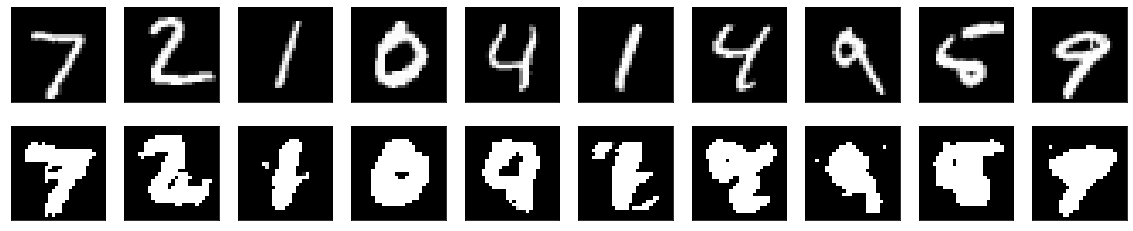

In [32]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(model_1(x_test)[index].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Dense, Multi Layer Model #2

### Define Model Architecture

In [3]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim_1, intermediate_dim_2, intermediate_dim_3):
        super(Encoder, self).__init__()
        self.hidden_layer_1 = Dense(units=intermediate_dim_1, activation="relu")
        self.hidden_layer_2 = Dense(units=intermediate_dim_2, activation="relu")
        self.hidden_layer_3 = Dense(units=intermediate_dim_3, activation="relu")
        self.output_layer = Dense(units=intermediate_dim_3, activation="relu")
    
    def call(self, input_features):
        hid_layer_1 = self.hidden_layer_1(input_features)
        hid_layer_2 = self.hidden_layer_2(hid_layer_1)
        hid_layer_3 = self.hidden_layer_3(hid_layer_2)
        return self.output_layer(hid_layer_3)

class Decoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim_1, intermediate_dim_2, original_dim):
        super(Decoder, self).__init__()
        self.hidden_layer_1 = Dense(units=intermediate_dim_1, activation="relu")
        self.hidden_layer_2 = Dense(units=intermediate_dim_2, activation="relu")
        self.output_layer = Dense(units=original_dim, activation="sigmoid")
  
    def call(self, code):
        hid_layer_1 = self.hidden_layer_1(code)
        hid_layer_2 = self.hidden_layer_2(hid_layer_1)
        return self.output_layer(hid_layer_2)

class Autoencoder(tf.keras.Model):
    def __init__(self, intermediate_dim_1, intermediate_dim_2, intermediate_dim_3, original_dim):
        super(Autoencoder, self).__init__()
        self.loss = []
        self.encoder = Encoder(intermediate_dim_1=intermediate_dim_1, intermediate_dim_2=intermediate_dim_2, 
                              intermediate_dim_3=intermediate_dim_3)
        self.decoder = Decoder(intermediate_dim_1=intermediate_dim_2, intermediate_dim_2=intermediate_dim_1, original_dim=original_dim)

    def call(self, input_features):
        code = self.encoder(input_features)
        reconstructed = self.decoder(code)
        return reconstructed

### Fit Model and Display Reconstructions

In [9]:
model_2 = Autoencoder(intermediate_dim_1=128, intermediate_dim_2=64, intermediate_dim_3=32, original_dim=784)
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)

train_loop(model_2, opt, loss, training_dataset, 100)

Epoch 1/100. Loss: 13.294869422912598
Epoch 2/100. Loss: 7.805337429046631
Epoch 3/100. Loss: 6.291321754455566
Epoch 4/100. Loss: 5.624683380126953
Epoch 5/100. Loss: 5.250584125518799
Epoch 6/100. Loss: 4.900790691375732
Epoch 7/100. Loss: 4.689581871032715
Epoch 8/100. Loss: 4.548285961151123
Epoch 9/100. Loss: 4.424587726593018
Epoch 10/100. Loss: 4.313777446746826
Epoch 11/100. Loss: 4.213231086730957
Epoch 12/100. Loss: 4.134562015533447
Epoch 13/100. Loss: 4.043300151824951
Epoch 14/100. Loss: 3.987767457962036
Epoch 15/100. Loss: 3.984928846359253
Epoch 16/100. Loss: 3.9912374019622803
Epoch 17/100. Loss: 3.8897242546081543
Epoch 18/100. Loss: 3.885559558868408
Epoch 19/100. Loss: 3.842142105102539
Epoch 20/100. Loss: 3.7659847736358643
Epoch 21/100. Loss: 3.7238574028015137
Epoch 22/100. Loss: 3.7125778198242188
Epoch 23/100. Loss: 3.649488925933838
Epoch 24/100. Loss: 3.6567912101745605
Epoch 25/100. Loss: 3.6338343620300293
Epoch 26/100. Loss: 3.6134591102600098
Epoch 27/100

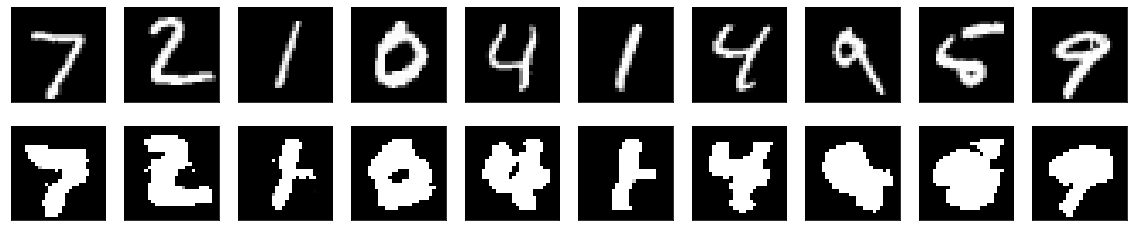

In [10]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(model_2(x_test)[index].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Dense, Multi Layer Model #3

### Define Model Architecture

In [11]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim_1, intermediate_dim_2, intermediate_dim_3):
        super(Encoder, self).__init__()
        self.hidden_layer_1 = Dense(units=intermediate_dim_1, activation=tf.nn.leaky_relu)
        self.hidden_layer_2 = Dense(units=intermediate_dim_2, activation=tf.nn.leaky_relu)
        self.hidden_layer_3 = Dense(units=intermediate_dim_3, activation=tf.nn.leaky_relu)
        self.output_layer = Dense(units=intermediate_dim_3, activation=tf.nn.leaky_relu)
    
    def call(self, input_features):
        hid_layer_1 = self.hidden_layer_1(input_features)
        hid_layer_2 = self.hidden_layer_2(hid_layer_1)
        hid_layer_3 = self.hidden_layer_3(hid_layer_2)
        return self.output_layer(hid_layer_3)

class Decoder(tf.keras.layers.Layer):
    def __init__(self, intermediate_dim_1, intermediate_dim_2, original_dim):
        super(Decoder, self).__init__()
        self.hidden_layer_1 = Dense(units=intermediate_dim_1, activation=tf.nn.leaky_relu)
        self.hidden_layer_2 = Dense(units=intermediate_dim_2, activation=tf.nn.leaky_relu)
        self.output_layer = Dense(units=original_dim, activation="sigmoid")
  
    def call(self, code):
        hid_layer_1 = self.hidden_layer_1(code)
        hid_layer_2 = self.hidden_layer_2(hid_layer_1)
        return self.output_layer(hid_layer_2)

class Autoencoder(tf.keras.Model):
    def __init__(self, intermediate_dim_1, intermediate_dim_2, intermediate_dim_3, original_dim):
        super(Autoencoder, self).__init__()
        self.loss = []
        self.encoder = Encoder(intermediate_dim_1=intermediate_dim_1, intermediate_dim_2=intermediate_dim_2, 
                              intermediate_dim_3=intermediate_dim_3)
        self.decoder = Decoder(intermediate_dim_1=intermediate_dim_2, intermediate_dim_2=intermediate_dim_1, original_dim=original_dim)

    def call(self, input_features):
        code = self.encoder(input_features)
        reconstructed = self.decoder(code)
        return reconstructed

### Fit Model and Display Reconstructions

In [14]:
model_3 = Autoencoder(intermediate_dim_1=128, intermediate_dim_2=64, intermediate_dim_3=32, original_dim=784)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

train_loop(model_3, opt, loss, training_dataset, 100)

Epoch 1/100. Loss: 15.69251823425293
Epoch 2/100. Loss: 8.378626823425293
Epoch 3/100. Loss: 6.532469272613525
Epoch 4/100. Loss: 5.413669586181641
Epoch 5/100. Loss: 4.7656073570251465
Epoch 6/100. Loss: 4.349132537841797
Epoch 7/100. Loss: 4.041588306427002
Epoch 8/100. Loss: 3.806246042251587
Epoch 9/100. Loss: 3.572021007537842
Epoch 10/100. Loss: 3.3831024169921875
Epoch 11/100. Loss: 3.2277231216430664
Epoch 12/100. Loss: 3.100938081741333
Epoch 13/100. Loss: 2.993419647216797
Epoch 14/100. Loss: 2.895158529281616
Epoch 15/100. Loss: 2.809995174407959
Epoch 16/100. Loss: 2.733919620513916
Epoch 17/100. Loss: 2.667064666748047
Epoch 18/100. Loss: 2.6032919883728027
Epoch 19/100. Loss: 2.5447630882263184
Epoch 20/100. Loss: 2.4924254417419434
Epoch 21/100. Loss: 2.443464756011963
Epoch 22/100. Loss: 2.3985772132873535
Epoch 23/100. Loss: 2.355250835418701
Epoch 24/100. Loss: 2.3137588500976562
Epoch 25/100. Loss: 2.2753281593322754
Epoch 26/100. Loss: 2.235426187515259
Epoch 27/100

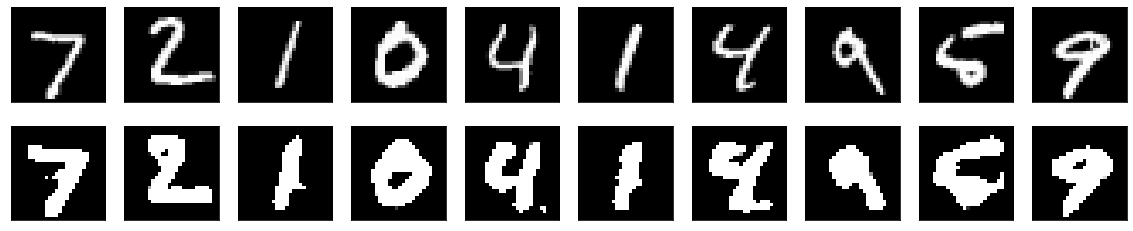

In [15]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(model_3(x_test)[index].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## CNN Basic Model (Given)

### Define Model Architecture

In [34]:
input_img = Input(shape=(28, 28, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

cnn_autoencoder = Model(input_img, decoded)
cnn_autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

### Read Images

In [2]:
from tensorflow.keras.datasets import mnist
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

11493376/11490434 [==============================] - 0s 0us/step


### Fit Model and Display Reconstructions

In [39]:
cnn_autoencoder.fit(x_train, x_train, epochs=100, batch_size=128, 
                shuffle=True, validation_data=(x_test, x_test), 
                callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tmp/autoencoder')])

Epoch 1/100
469/469 [==============================] - 34s 13ms/step - loss: 0.6864 - val_loss: 0.6824
Epoch 2/100
469/469 [==============================] - 5s 10ms/step - loss: 0.6804 - val_loss: 0.6735
Epoch 3/100
469/469 [==============================] - 5s 10ms/step - loss: 0.6698 - val_loss: 0.6560
Epoch 4/100
469/469 [==============================] - 5s 10ms/step - loss: 0.6477 - val_loss: 0.6148
Epoch 5/100
469/469 [==============================] - 5s 11ms/step - loss: 0.5956 - val_loss: 0.5368
Epoch 6/100
469/469 [==============================] - 5s 11ms/step - loss: 0.5231 - val_loss: 0.5094
Epoch 7/100
469/469 [==============================] - 5s 10ms/step - loss: 0.5036 - val_loss: 0.5026
Epoch 8/100
469/469 [==============================] - 5s 11ms/step - loss: 0.4976 - val_loss: 0.4970
Epoch 9/100
469/469 [==============================] - 5s 11ms/step - loss: 0.4915 - val_loss: 0.4920
Epoch 10/100
469/469 [==============================] - 5s 10ms/step - loss: 0.48

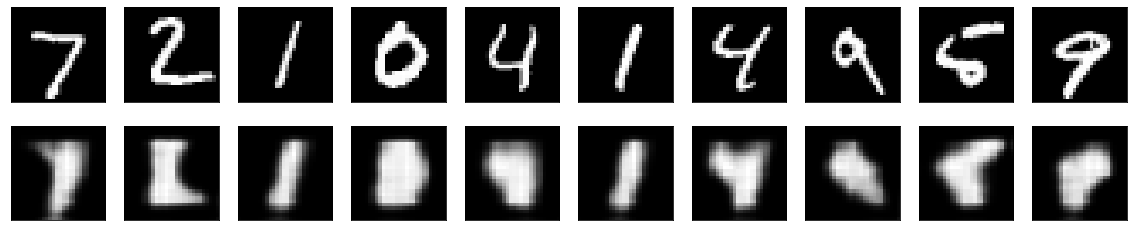

In [42]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(cnn_autoencoder(x_test)[index].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## CNN Complex Model #1

### Define Model Architecture

In [3]:
input_img = Input(shape=(28, 28, 1)) # adapt this if using `channels_first` image data format

x1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x1 = MaxPooling2D((2, 2), padding='same')(x1)
x1 = Conv2D(8, (3, 3), activation='relu', padding='same')(x1)
x1 = MaxPooling2D((2, 2), padding='same')(x1)
x1 = Conv2D(8, (3, 3), activation='relu', padding='same')(x1)
encoded1 = MaxPooling2D((2, 2), padding='same')(x1)

x1 = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded1)
x1 = UpSampling2D((2, 2))(x1)
x1 = Conv2D(8, (3, 3), activation='relu', padding='same')(x1)
x1 = UpSampling2D((2, 2))(x1)
x1 = Conv2D(16, (3, 3), activation='relu')(x1)
x1 = UpSampling2D((2, 2))(x1)
decoded1 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x1)

cnn_autoencoder_1 = Model(input_img, decoded1)
cnn_autoencoder_1.compile(optimizer='adam', loss='binary_crossentropy')

### Fit Model and Display Reconstructions

In [4]:
cnn_autoencoder_1.fit(x_train, x_train, epochs=100, batch_size=256, 
                shuffle=True, validation_data=(x_test, x_test), 
                callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tmp/autoencoder')])

Epoch 1/100
235/235 [==============================] - 35s 21ms/step - loss: 0.4697 - val_loss: 0.1795
Epoch 2/100
235/235 [==============================] - 4s 15ms/step - loss: 0.1697 - val_loss: 0.1483
Epoch 3/100
235/235 [==============================] - 4s 16ms/step - loss: 0.1460 - val_loss: 0.1357
Epoch 4/100
235/235 [==============================] - 4s 16ms/step - loss: 0.1355 - val_loss: 0.1291
Epoch 5/100
235/235 [==============================] - 4s 16ms/step - loss: 0.1292 - val_loss: 0.1250
Epoch 6/100
235/235 [==============================] - 4s 15ms/step - loss: 0.1251 - val_loss: 0.1213
Epoch 7/100
235/235 [==============================] - 4s 15ms/step - loss: 0.1221 - val_loss: 0.1193
Epoch 8/100
235/235 [==============================] - 4s 15ms/step - loss: 0.1200 - val_loss: 0.1174
Epoch 9/100
235/235 [==============================] - 4s 15ms/step - loss: 0.1184 - val_loss: 0.1157
Epoch 10/100
235/235 [==============================] - 4s 15ms/step - loss: 0.11

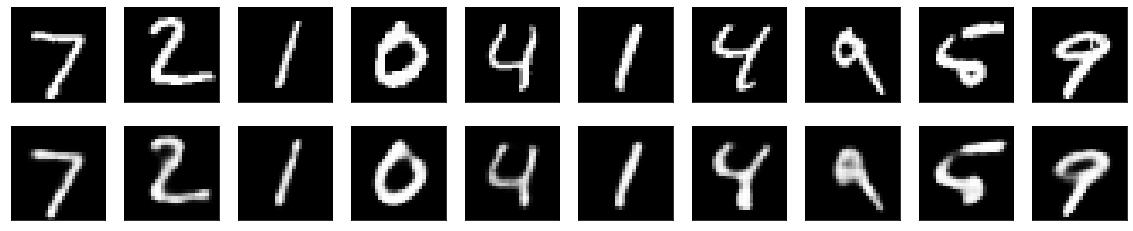

In [5]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(cnn_autoencoder_1(x_test)[index].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## CNN Complex Model #2

### Define Model Architecture

In [28]:
input_img = Input(shape=(28, 28, 1)) # adapt this if using `channels_first` image data format

x2 = Conv2D(32, (3, 3), padding='same')(input_img)
x2 = LeakyReLU()(x2)
x2 = MaxPooling2D((2, 2), padding='same')(x2)
x2 = Conv2D(16, (3, 3), padding='same')(x2)
x2 = LeakyReLU()(x2)
x2 = MaxPooling2D((2, 2), padding='same')(x2)
x2 = Conv2D(8, (3, 3), padding='same')(x2)
x2 = LeakyReLU()(x2)
x2 = BatchNormalization()(x2)
encoded1 = MaxPooling2D((2, 2), padding='same')(x2)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x2 = Conv2D(8, (3, 3), padding='same')(encoded1)
x2 = LeakyReLU()(x2)
x2 = UpSampling2D((2, 2))(x2)
x2 = Conv2D(16, (3, 3), padding='same')(x2)
x2 = LeakyReLU()(x2)
x2 = UpSampling2D((2, 2))(x2)
x2 = Conv2D(32, (3, 3))(x2)
x2 = LeakyReLU()(x2)
x2 = UpSampling2D((2, 2))(x2)
x2 = BatchNormalization()(x2)
decoded1 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x2)

cnn_autoencoder_2 = Model(input_img, decoded1)
cnn_autoencoder_2.compile(optimizer='adam', loss='binary_crossentropy')

### Fit Model and Display Reconstructions

In [29]:
cnn_autoencoder_2.fit(x_train, x_train, epochs=100, batch_size=128, 
                shuffle=True, validation_data=(x_test, x_test), 
                callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tmp/autoencoder')])

Epoch 1/100
469/469 [==============================] - 9s 16ms/step - loss: 0.3413 - val_loss: 0.1387
Epoch 2/100
469/469 [==============================] - 7s 14ms/step - loss: 0.1216 - val_loss: 0.1103
Epoch 3/100
469/469 [==============================] - 7s 14ms/step - loss: 0.1089 - val_loss: 0.1103
Epoch 4/100
469/469 [==============================] - 7s 14ms/step - loss: 0.1034 - val_loss: 0.0981
Epoch 5/100
469/469 [==============================] - 7s 14ms/step - loss: 0.0992 - val_loss: 0.0992
Epoch 6/100
469/469 [==============================] - 7s 14ms/step - loss: 0.0964 - val_loss: 0.0996
Epoch 7/100
469/469 [==============================] - 7s 14ms/step - loss: 0.0944 - val_loss: 0.0999
Epoch 8/100
469/469 [==============================] - 7s 14ms/step - loss: 0.0927 - val_loss: 0.0930
Epoch 9/100
469/469 [==============================] - 7s 14ms/step - loss: 0.0913 - val_loss: 0.0936
Epoch 10/100
469/469 [==============================] - 7s 14ms/step - loss: 0.090

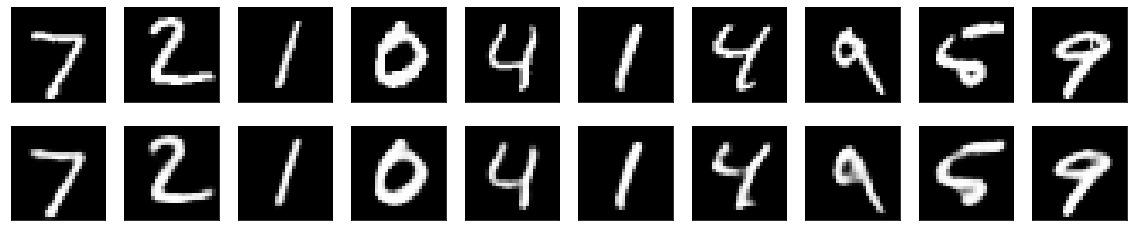

In [30]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(cnn_autoencoder_2(x_test)[index].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Task 2 - Denoising autoencoder

## Dense, multi-layer model & CNN Basic Model [given]

### Read Images and add noise

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Introduce noise with a probability factor of 0.5
noise_factor = 0.5
x_train_noisy = x_train + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# # Reshaping the noise into 784 pixels (28*28)
x_train_noisy = np.reshape(x_train_noisy, (x_train_noisy.shape[0], 784))
x_test_noisy = np.reshape(x_test_noisy, (x_test_noisy.shape[0], 784))
x_train_noisy = x_train_noisy.astype('float32')
x_test_noisy = x_test_noisy.astype('float32')
training_dataset = tf.data.Dataset.from_tensor_slices(x_train_noisy).batch(256)

11493376/11490434 [==============================] - 0s 0us/step


### View noisy images

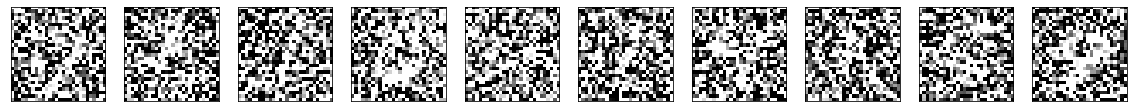

In [ ]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Fit models on noisy data and view reconstructions

### Dense, multi layer model (given)

In [41]:
model = Autoencoder(intermediate_dim=128, original_dim=784)
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)

train_loop(model, opt, loss, training_dataset, 100)

Epoch 1/100. Loss: 90.38638305664062
Epoch 2/100. Loss: 47.40509796142578
Epoch 3/100. Loss: 47.38875961303711
Epoch 4/100. Loss: 47.374752044677734
Epoch 5/100. Loss: 47.29644775390625
Epoch 6/100. Loss: 47.265262603759766
Epoch 7/100. Loss: 47.207176208496094
Epoch 8/100. Loss: 47.19213104248047
Epoch 9/100. Loss: 47.13450241088867
Epoch 10/100. Loss: 47.00113296508789
Epoch 11/100. Loss: 46.90769577026367
Epoch 12/100. Loss: 46.78653335571289
Epoch 13/100. Loss: 46.785560607910156
Epoch 14/100. Loss: 46.7843132019043
Epoch 15/100. Loss: 46.71820068359375
Epoch 16/100. Loss: 46.5715217590332
Epoch 17/100. Loss: 46.4844970703125
Epoch 18/100. Loss: 46.177711486816406
Epoch 19/100. Loss: 46.06391143798828
Epoch 20/100. Loss: 46.05824661254883
Epoch 21/100. Loss: 46.0567741394043
Epoch 22/100. Loss: 46.05447006225586
Epoch 23/100. Loss: 46.05058670043945
Epoch 24/100. Loss: 46.049293518066406
Epoch 25/100. Loss: 46.04798889160156
Epoch 26/100. Loss: 45.97773742675781
Epoch 27/100. Loss:

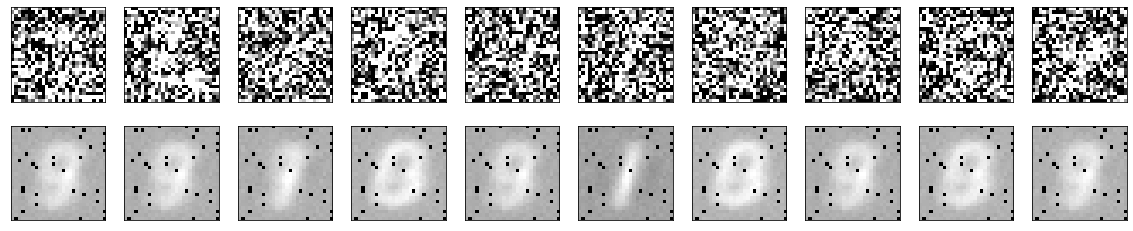

In [42]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(model(x_test_noisy)[i].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### CNN Basic Model (given)

In [ ]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Introduce noise with a probability factor of 0.5
noise_factor = 0.5
x_train_noisy = x_train + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [36]:
cnn_autoencoder.fit(x_train_noisy, x_train, epochs=100, batch_size=128, 
                shuffle=True, validation_data=(x_test_noisy, x_test), 
                callbacks=[tf.keras.callbacks.TensorBoard(log_dir='./tmp/tb', histogram_freq=0, write_graph=False)])

Epoch 1/100
469/469 [==============================] - 6s 12ms/step - loss: 0.7153 - val_loss: 0.7083
Epoch 2/100
469/469 [==============================] - 5s 11ms/step - loss: 0.7019 - val_loss: 0.6955
Epoch 3/100
469/469 [==============================] - 5s 11ms/step - loss: 0.6887 - val_loss: 0.6816
Epoch 4/100
469/469 [==============================] - 5s 11ms/step - loss: 0.6713 - val_loss: 0.6580
Epoch 5/100
469/469 [==============================] - 5s 11ms/step - loss: 0.6269 - val_loss: 0.5806
Epoch 6/100
469/469 [==============================] - 5s 11ms/step - loss: 0.5140 - val_loss: 0.4768
Epoch 7/100
469/469 [==============================] - 5s 11ms/step - loss: 0.4668 - val_loss: 0.4651
Epoch 8/100
469/469 [==============================] - 5s 11ms/step - loss: 0.4566 - val_loss: 0.4549
Epoch 9/100
469/469 [==============================] - 5s 11ms/step - loss: 0.4459 - val_loss: 0.4434
Epoch 10/100
469/469 [==============================] - 5s 11ms/step - loss: 0.432

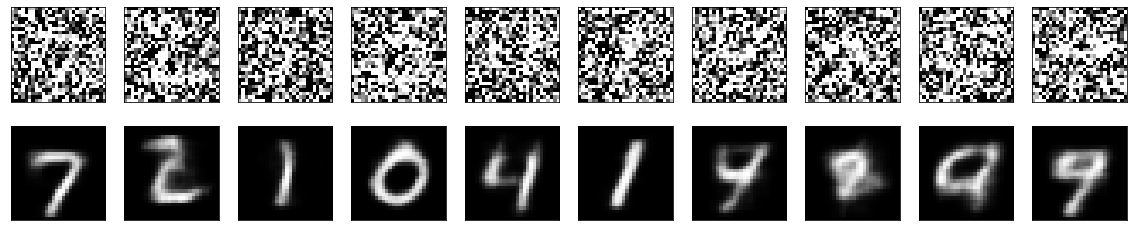

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(cnn_autoencoder_2(x_test_noisy)[i].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## CNN Complex Model #1

### Define Model Architecture

In [10]:
input_img = Input(shape=(28, 28, 1))

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

cnn_autoencoder_1 = Model(input_img, decoded)
optimizer = Adam(learning_rate=0.03)
cnn_autoencoder_1.compile(optimizer=optimizer, loss='binary_crossentropy')

### Fit Model and Display Reconstruction

In [11]:
cnn_autoencoder_1.fit(x_train_noisy, x_train, epochs=100, batch_size=256, shuffle=True, validation_data= (x_test_noisy, x_test))

Epoch 1/100
235/235 [==============================] - 8s 29ms/step - loss: 0.3185 - val_loss: 0.5419
Epoch 2/100
235/235 [==============================] - 7s 28ms/step - loss: 0.1838 - val_loss: 0.2330
Epoch 3/100
235/235 [==============================] - 7s 28ms/step - loss: 0.1787 - val_loss: 0.2095
Epoch 4/100
235/235 [==============================] - 7s 28ms/step - loss: 0.1752 - val_loss: 0.3242
Epoch 5/100
235/235 [==============================] - 7s 29ms/step - loss: 0.1745 - val_loss: 0.2445
Epoch 6/100
235/235 [==============================] - 7s 28ms/step - loss: 0.1725 - val_loss: 0.1736
Epoch 7/100
235/235 [==============================] - 7s 28ms/step - loss: 0.1708 - val_loss: 0.1814
Epoch 8/100
235/235 [==============================] - 7s 28ms/step - loss: 0.1689 - val_loss: 0.2074
Epoch 9/100
235/235 [==============================] - 7s 28ms/step - loss: 0.1679 - val_loss: 0.1959
Epoch 10/100
235/235 [==============================] - 7s 28ms/step - loss: 0.167

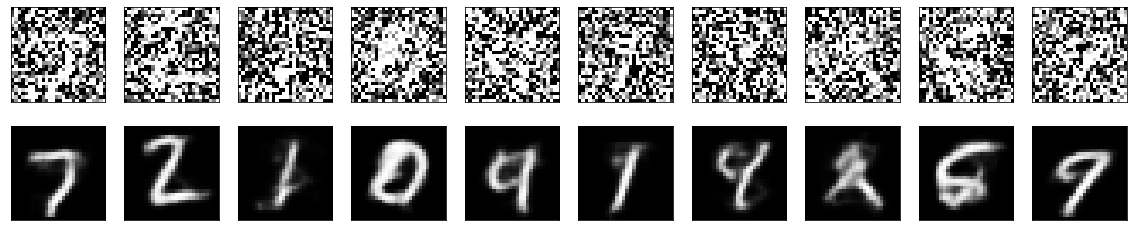

In [12]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(cnn_autoencoder_1(x_test_noisy)[i].numpy().reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Task 3 - Text Reconstruction Application

## Upload Images to current work session

In [31]:
import zipfile
with zipfile.ZipFile("CS6421---Assignment-2/test.zip", 'r') as zip_ref:
    zip_ref.extractall()
with zipfile.ZipFile("CS6421---Assignment-2/train.zip", 'r') as zip_ref:
    zip_ref.extractall()
with zipfile.ZipFile("CS6421---Assignment-2/train_cleaned.zip", 'r') as zip_ref:
    zip_ref.extractall()

## Define Loss Function - RMSE

In [4]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

## Dense, Multi layer Model

### Define Model Architecture

In [10]:
def build_autoenocder():
    input_img = Input(shape=(226800,), name='image_input')
    
    #enoder 
    encoded_1 = Dense(1024, activation='relu')(input_img)
    encoded_1 = Dense(512, activation='relu')(encoded_1)
    encoded_1 = Dense(256, activation='relu')(encoded_1)
    encoded_1 = Dense(128, activation='relu')(encoded_1)
    encoded_1 = Dense(64, activation='relu')(encoded_1)

    # decoder
    decoded_1 = Dense(128, activation='relu')(encoded_1)
    decoded_1 = Dense(256, activation='relu')(decoded_1)
    decoded_1 = Dense(512, activation='relu')(decoded_1)
    decoded_1 = Dense(1024, activation='relu')(decoded_1)
    
    decoded_1 = Dense(226800, activation='sigmoid')(decoded_1)
    
    #model
    autoencoder = Model(input_img, decoded_1)
    optimizer = Adam(learning_rate= 0.0001)
    autoencoder.compile(optimizer=optimizer, loss=root_mean_squared_error)
    return autoencoder

autoencoder = build_autoenocder()
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 226800)]          0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              232244224 
_________________________________________________________________
dense_11 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_13 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_15 (Dense)             (None, 128)               8320

### Read Images

In [6]:
train = Path('/content/train')
train_cleaned = Path('/content/train_cleaned')
test = Path('/content/test')

train_images = sorted(os.listdir(train))
train_labels = sorted(os.listdir(train_cleaned))
test_images = sorted(os.listdir(test))

X = [] # Training data - Noisy 
Y = [] # Training data - Labels
O = [] # Test data

# Train - Noisy
for img in train_images:
    img = load_img(train / img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    X.append(img)

# Train - Clean
for img in train_labels:
    img = load_img(train_cleaned / img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    Y.append(img)

# Test
for img in test_images:
    img = load_img(test / img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    O.append(img)

X = np.array(X)
Y = np.array(Y)
O = np.array(O)

# Split the dataset into training and validation. Always set the random state!!
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=6421)
print("Total number of training samples: ", X_train.shape)
print("Total number of validation samples: ", X_valid.shape)

# Flattening images
X_train = np.reshape(X_train, (X_train.shape[0], 226800))
X_valid = np.reshape(X_valid, (X_valid.shape[0], 226800))

y_train = np.reshape(y_train, (y_train.shape[0], 226800))
y_valid = np.reshape(y_valid, (y_valid.shape[0], 226800))

test_images = np.reshape(O,(O.shape[0], 226800))

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Total number of training samples:  (129, 420, 540, 1)
Total number of validation samples:  (15, 420, 540, 1)


### Fit Model and Display Reconstructions

In [16]:
autoencoder.fit(X_train, y_train,
                epochs=100,
                batch_size=8,
                shuffle=True,
                validation_data=(X_valid, y_valid))


Epoch 1/100
17/17 [==============================] - 2s 113ms/step - loss: 0.2135 - val_loss: 0.2242
Epoch 2/100
17/17 [==============================] - 2s 108ms/step - loss: 0.2030 - val_loss: 0.2232
Epoch 3/100
17/17 [==============================] - 2s 107ms/step - loss: 0.2027 - val_loss: 0.2527
Epoch 4/100
17/17 [==============================] - 2s 108ms/step - loss: 0.2085 - val_loss: 0.2410
Epoch 5/100
17/17 [==============================] - 2s 108ms/step - loss: 0.2096 - val_loss: 0.2337
Epoch 6/100
17/17 [==============================] - 2s 109ms/step - loss: 0.2021 - val_loss: 0.2180
Epoch 7/100
17/17 [==============================] - 2s 110ms/step - loss: 0.1960 - val_loss: 0.2231
Epoch 8/100
17/17 [==============================] - 2s 109ms/step - loss: 0.1953 - val_loss: 0.2234
Epoch 9/100
17/17 [==============================] - 2s 109ms/step - loss: 0.1948 - val_loss: 0.2159
Epoch 10/100
17/17 [==============================] - 2s 109ms/step - loss: 0.1925 - val_lo

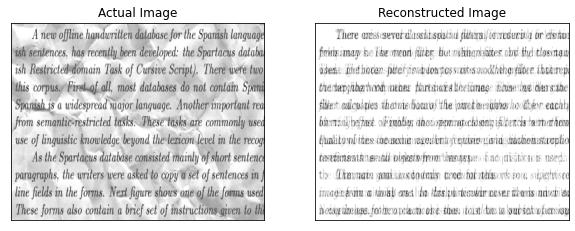

In [17]:
# Compute the prediction
predicted_label = np.squeeze(autoencoder.predict(test_images))

f, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(np.squeeze(test_images[1].reshape(420,540)), cmap='gray')
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ax[0].set_title("Actual Image")

ax[1].imshow(np.squeeze(predicted_label[1].reshape(420,540)), cmap='gray')
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
ax[1].set_title("Reconstructed Image")
plt.show()

## CNN Basic Model

### Define Model Architecture

In [28]:
def build_autoencoder():
  input_img = Input(shape=(420, 540, 1))
 
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  encoded = MaxPooling2D((2, 2), padding='same')(x)
 
  x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(16, (3, 3), activation='relu')(x)
  x = UpSampling2D((2, 2))(x)
  decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
 
  autoencoder = Model(input_img, decoded)
  autoencoder.compile(optimizer = 'adam', loss = root_mean_squared_error)
  return autoencoder

cnn_basic = build_autoencoder()
cnn_basic.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 420, 540, 1)]     0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 420, 540, 16)      160       
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 210, 270, 16)      0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 210, 270, 16)      2320      
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 105, 135, 16)      0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 105, 135, 8)       1160      
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 53, 68, 8)         0  

### Read Images

In [32]:
train = Path('/content/train')
train_cleaned = Path('/content/train_cleaned')
test = Path('/content/test')
 
train_images = sorted(os.listdir(train))
train_labels = sorted(os.listdir(train_cleaned))
test_images = sorted(os.listdir(test))
 
X = [] # Training data - Noisy 
Y = [] # Training data - Labels
O = [] # Test data
 
# Train - Noisy
for img in train_images:
    img = load_img(train / img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    X.append(img)
 
# Train - Clean
for img in train_labels:
    img = load_img(train_cleaned / img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    Y.append(img)
 
# Test
for img in test_images:
    img = load_img(test / img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    O.append(img)
 
X = np.array(X)
Y = np.array(Y)
O = np.array(O)
 
# Split the dataset into training and validation. Always set the random state!!
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=6421)
print("Total number of training samples: ", X_train.shape)
print("Total number of validation samples: ", X_valid.shape)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Total number of training samples:  (129, 420, 540, 1)
Total number of validation samples:  (15, 420, 540, 1)


### Fit Model and Display Reconstructions

In [29]:
cnn_basic.fit(X_train, y_train,
                epochs=100,
                batch_size=8,
                shuffle=True,
                validation_data=(X_valid, y_valid))

Epoch 1/100
17/17 [==============================] - 2s 61ms/step - loss: 0.4090 - val_loss: 0.2937
Epoch 2/100
17/17 [==============================] - 1s 50ms/step - loss: 0.2837 - val_loss: 0.2970
Epoch 3/100
17/17 [==============================] - 1s 50ms/step - loss: 0.2864 - val_loss: 0.2938
Epoch 4/100
17/17 [==============================] - 1s 49ms/step - loss: 0.2749 - val_loss: 0.2772
Epoch 5/100
17/17 [==============================] - 1s 50ms/step - loss: 0.2663 - val_loss: 0.2752
Epoch 6/100
17/17 [==============================] - 1s 49ms/step - loss: 0.2634 - val_loss: 0.2721
Epoch 7/100
17/17 [==============================] - 1s 51ms/step - loss: 0.2613 - val_loss: 0.2628
Epoch 8/100
17/17 [==============================] - 1s 49ms/step - loss: 0.2491 - val_loss: 0.2499
Epoch 9/100
17/17 [==============================] - 1s 50ms/step - loss: 0.2389 - val_loss: 0.2447
Epoch 10/100
17/17 [==============================] - 1s 50ms/step - loss: 0.2347 - val_loss: 0.2422

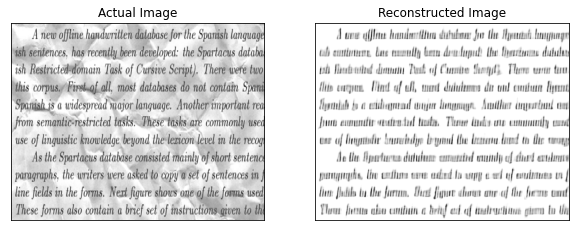

In [30]:
# Compute the prediction
predicted_label = np.squeeze(cnn_basic.predict(O))

f, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(np.squeeze(O[1].reshape(420,540)), cmap='gray')
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ax[0].set_title("Actual Image")

ax[1].imshow(np.squeeze(predicted_label[1].reshape(420,540)), cmap='gray')
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
ax[1].set_title("Reconstructed Image")
plt.show()

## CNN Complex Model #1

### Define Model Architecture

In [46]:
def build_autoencoder():
  input_img = Input(shape=(420, 540, 1))

  x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
  encoded = MaxPooling2D((2, 2), padding='same')(x)

  x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
  x = Conv2D(32, (3, 3), activation='relu', padding ='same')(x)
  x = UpSampling2D((2, 2))(x)
  decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

  autoencoder = Model(input_img, decoded)
  optimizer = Adam(learning_rate=0.0003)
  autoencoder.compile(optimizer = optimizer, loss = root_mean_squared_error)
  return autoencoder

cnn_complex_1 = build_autoencoder()
cnn_complex_1.summary()

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 420, 540, 1)]     0         
_________________________________________________________________
conv2d_182 (Conv2D)          (None, 420, 540, 32)      320       
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 210, 270, 32)      0         
_________________________________________________________________
conv2d_183 (Conv2D)          (None, 210, 270, 16)      4624      
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 105, 135, 16)      0         
_________________________________________________________________
conv2d_184 (Conv2D)          (None, 105, 135, 16)      2320      
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 53, 68, 16)        0  

### Fit Model and Display Reconstructions

In [50]:
cnn_complex_1 = build_autoencoder()
cnn_complex_1.fit(X_train, y_train,
                epochs=100,
                batch_size=8,
                shuffle=True,
                validation_data=(X_valid, y_valid))

Epoch 1/100
17/17 [==============================] - 2s 87ms/step - loss: 0.4249 - val_loss: 0.2813
Epoch 2/100
17/17 [==============================] - 1s 77ms/step - loss: 0.2728 - val_loss: 0.2890
Epoch 3/100
17/17 [==============================] - 1s 77ms/step - loss: 0.2768 - val_loss: 0.2780
Epoch 4/100
17/17 [==============================] - 1s 77ms/step - loss: 0.2660 - val_loss: 0.2745
Epoch 5/100
17/17 [==============================] - 1s 77ms/step - loss: 0.2597 - val_loss: 0.2669
Epoch 6/100
17/17 [==============================] - 1s 78ms/step - loss: 0.2503 - val_loss: 0.2514
Epoch 7/100
17/17 [==============================] - 1s 78ms/step - loss: 0.2399 - val_loss: 0.2445
Epoch 8/100
17/17 [==============================] - 1s 78ms/step - loss: 0.2324 - val_loss: 0.2429
Epoch 9/100
17/17 [==============================] - 1s 78ms/step - loss: 0.2319 - val_loss: 0.2414
Epoch 10/100
17/17 [==============================] - 1s 79ms/step - loss: 0.2320 - val_loss: 0.2394

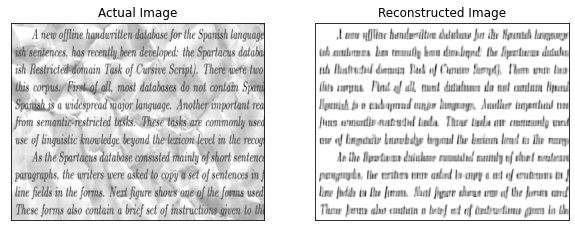

In [51]:
# Compute the prediction
predicted_label = np.squeeze(cnn_complex_1.predict(O))

f, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(np.squeeze(O[1].reshape(420,540)), cmap='gray')
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ax[0].set_title("Actual Image")

ax[1].imshow(np.squeeze(predicted_label[1].reshape(420,540)), cmap='gray')
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
ax[1].set_title("Reconstructed Image")
plt.show()

## CNN Complex Model #2

### Define Model Architecture

In [33]:
def build_autoencoder():
  input_img = Input(shape=(420, 540, 1))

  x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
  x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  encoded = MaxPooling2D((2, 2), padding='same')(x)

  x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = UpSampling2D((2, 2))(x)
  decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

  autoencoder = Model(input_img, decoded)
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0009)
  autoencoder.compile(optimizer = optimizer, loss = root_mean_squared_error)
  return autoencoder

cnn_complex_2 = build_autoencoder()
cnn_complex_2.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 420, 540, 1)]     0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 420, 540, 32)      320       
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 420, 540, 16)      4624      
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 420, 540, 8)       1160      
_________________________________________________________________
batch_normalization_22 (Batc (None, 420, 540, 8)       32        
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 210, 270, 8)       0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 210, 270, 8)       584

### Fit Model and Display Reconstructions

In [34]:
cnn_complex_2.fit(X_train, y_train,
                epochs=100,
                batch_size=8,
                shuffle=True,
                validation_data=(X_valid, y_valid))

Epoch 1/100
17/17 [==============================] - 3s 133ms/step - loss: 0.4459 - val_loss: 0.4484
Epoch 2/100
17/17 [==============================] - 2s 126ms/step - loss: 0.3146 - val_loss: 0.4083
Epoch 3/100
17/17 [==============================] - 2s 125ms/step - loss: 0.2456 - val_loss: 0.3578
Epoch 4/100
17/17 [==============================] - 2s 125ms/step - loss: 0.2064 - val_loss: 0.3204
Epoch 5/100
17/17 [==============================] - 2s 127ms/step - loss: 0.1799 - val_loss: 0.2931
Epoch 6/100
17/17 [==============================] - 2s 127ms/step - loss: 0.1571 - val_loss: 0.2775
Epoch 7/100
17/17 [==============================] - 2s 127ms/step - loss: 0.1391 - val_loss: 0.2733
Epoch 8/100
17/17 [==============================] - 2s 128ms/step - loss: 0.1224 - val_loss: 0.2717
Epoch 9/100
17/17 [==============================] - 2s 128ms/step - loss: 0.1084 - val_loss: 0.2726
Epoch 10/100
17/17 [==============================] - 2s 129ms/step - loss: 0.0949 - val_lo

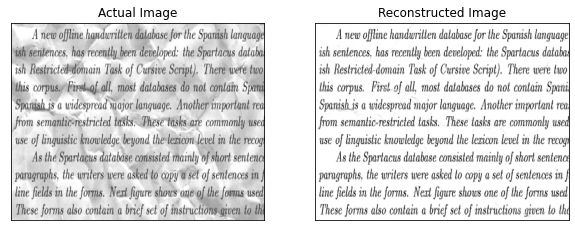

In [36]:
# Compute the prediction
predicted_label = np.squeeze(cnn_complex_2.predict(O))

f, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(np.squeeze(O[1].reshape(420,540)), cmap='gray')
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ax[0].set_title("Actual Image")

ax[1].imshow(np.squeeze(predicted_label[1].reshape(420,540)), cmap='gray')
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
ax[1].set_title("Reconstructed Image")
plt.show()

## CNN Complex Model #3

### Define Model and Architecture

In [63]:
def build_autoencoder():
  input_img = Input(shape=(420, 540, 1))

  x = Conv2D(64, (3, 3), padding='same')(input_img)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)
  x = Conv2D(32, (3, 3), padding='same')(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)
  x = Conv2D(32, (3, 3), padding='same')(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)
  encoded = MaxPooling2D((2, 2), padding='same')(x)

  x = Conv2D(32, (3, 3), padding='same')(encoded)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)
  x = Conv2D(32, (3, 3), padding='same')(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)
  x = Conv2D(64, (3, 3), padding='same')(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)
  x = UpSampling2D((2, 2))(x)
  decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

  autoencoder = Model(input_img, decoded)
  optimizer = Adam(learning_rate=0.001)
  autoencoder.compile(optimizer = optimizer, loss = root_mean_squared_error)
  return autoencoder

cnn_complex_3 = build_autoencoder()
cnn_complex_3.summary()

Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        [(None, 420, 540, 1)]     0         
_________________________________________________________________
conv2d_238 (Conv2D)          (None, 420, 540, 64)      640       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 420, 540, 64)      0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 420, 540, 64)      256       
_________________________________________________________________
conv2d_239 (Conv2D)          (None, 420, 540, 32)      18464     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 420, 540, 32)      0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 420, 540, 32)      128

### Fit Model and Display Reconstructions

In [64]:
cnn_complex_3.fit(X_train, y_train,
                epochs=100,
                batch_size=4,
                shuffle=True,
                validation_data=(X_valid, y_valid))

Epoch 1/100
33/33 [==============================] - 6s 164ms/step - loss: 0.3386 - val_loss: 0.2959
Epoch 2/100
33/33 [==============================] - 5s 163ms/step - loss: 0.1703 - val_loss: 0.2789
Epoch 3/100
33/33 [==============================] - 5s 166ms/step - loss: 0.1242 - val_loss: 0.2882
Epoch 4/100
33/33 [==============================] - 5s 166ms/step - loss: 0.0987 - val_loss: 0.2921
Epoch 5/100
33/33 [==============================] - 5s 165ms/step - loss: 0.0891 - val_loss: 0.2908
Epoch 6/100
33/33 [==============================] - 5s 162ms/step - loss: 0.0794 - val_loss: 0.2913
Epoch 7/100
33/33 [==============================] - 5s 159ms/step - loss: 0.0887 - val_loss: 0.2573
Epoch 8/100
33/33 [==============================] - 5s 157ms/step - loss: 0.0804 - val_loss: 0.2706
Epoch 9/100
33/33 [==============================] - 5s 157ms/step - loss: 0.0687 - val_loss: 0.2769
Epoch 10/100
33/33 [==============================] - 5s 156ms/step - loss: 0.0651 - val_lo

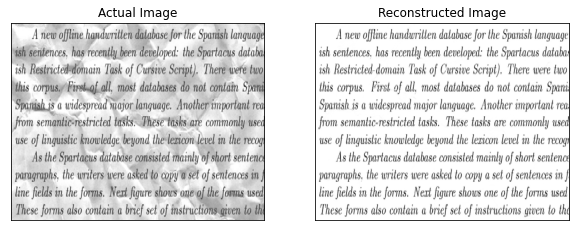

In [65]:
# Compute the prediction
predicted_label = np.squeeze(cnn_complex_3.predict(O))

f, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(np.squeeze(O[1].reshape(420,540)), cmap='gray')
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ax[0].set_title("Actual Image")

ax[1].imshow(np.squeeze(predicted_label[1].reshape(420,540)), cmap='gray')
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
ax[1].set_title("Reconstructed Image")
plt.show()